# Feature Selection – Numeric data  
### Introduction  
When we work with data in table form—like a spreadsheet—each row usually represents one person or thing, and each column is a piece of information about them. For example, a person might have columns like age, weight, blood pressure, or glucose level.

But not every column is useful when we’re trying to train a machine learning model. Some columns might be irrelevant or even distracting. *Feature selection* is the process of choosing only the columns that really help with the prediction task.

Doing this can:

- Make the model faster and more accurate  
- Avoid “overthinking” (overfitting) by the model  
- Make the results easier to understand

We’ll look at a few simple ways to do this:

- *Filter-based*: Use basic maths to decide which columns are not useful (e.g. if they don’t change much or are not related to the outcome).  
- *Wrapper-based*: Try out different combinations of columns and see which ones work best with the model.  
- *Embedded*: Let the model itself choose what’s useful while it trains.  
- *PCA (Principal Component Analysis)*: A special technique that combines and simplifies columns into fewer, more powerful ones.

We’ll show how this works using a dataset about diabetes risk in women, but these techniques can be used with all kinds of number-based data—like in health, finance, or engineering.

### Installing Python libraries

In [1]:
%pip install --upgrade pip -q

%pip install pandas numpy matplotlib scikit-learn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Download the data

In [2]:
import urllib.request

url = 'https://raw.githubusercontent.com/martyn-harris-bbk/AppliedMachineLearning/main/data/pima-indians-diabetes.data.csv'
filename = 'pima-indians-diabetes.data.csv'

urllib.request.urlretrieve(url, filename)

print("Download complete.")


Download complete.


### Load the data

When we load the dataset, and separate it into two distinct parts. The first eight columns become our *features*, stored in the variable `X`. These are the measurements our machine learning model will use to learn patterns. The final column is the *target*, and we store the rows in variable `Y`. This target indicates whether the patient has diabetes (`1`) or not (`0`) based on the features.

Once loaded, the features (`X`) will then be used as input data to train the machine learning model, while the target variable (`Y`) is the outcome the model will try to predict:

In [3]:
import pandas as pd

header = [
    'Pregnancy_Count',
    'Glucone_conc',
    'Blood_pressure',
    'Skin_thickness',
    'Insulin',
    'BMI',
    'DPF',
    'Age',
    'Class'
]

data = pd.read_csv(url, names=header)

print(data.head())

array = data.values

X = array[:, 0:8]
Y = array[:, 8]

print("Data shape:", data.shape)


   Pregnancy_Count  Glucone_conc  Blood_pressure  Skin_thickness  Insulin  \
0                6           148              72              35        0   
1                1            85              66              29        0   
2                8           183              64               0        0   
3                1            89              66              23       94   
4                0           137              40              35      168   

    BMI    DPF  Age  Class  
0  33.6  0.627   50      1  
1  26.6  0.351   31      0  
2  23.3  0.672   32      1  
3  28.1  0.167   21      0  
4  43.1  2.288   33      1  
Data shape: (768, 9)


Above, each row is one patient with numeric features like pregnancy count, glucose level, blood pressure, etc. The final column `class` indicates whether the patient had diabetes.

## Filter-based methods  

Filter-based methods are a quick and simple way to decide which columns of data are useful before we train any machine learning model. They use basic statistics to score or rank each column (or *feature*) on its own, without involving any model at this stage.

These methods help us:

- Remove features that do not vary much or are not helpful  
- Make the model faster and easier to train  
- Reduce the chances of overfitting (when a model learns noise instead of useful patterns)

Because they do not rely on any specific type of model, they can be used on many different kinds of datasets.

Two common examples are:

- *Variance threshold*: Removes features that barely change across the data  
- *Chi-square test*: Looks at the relationship between each feature and the outcome to see if it is useful

### Variance threshold

The variance threshold method removes features with low variance, under the assumption that features with little variability carry minimal predictive power. This is particularly useful in high-dimensional datasets where constant or near-constant features add noise without contributing meaningful information. The chi-square test, on the other hand, is useful for categorical data, measuring the statistical dependence between a feature and the target variable.

In [4]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold  

# Define a threshold for minimum variance
threshold_n = 0.75

# Create a VarianceThreshold object using the formula: p * (1 - p)
# This is useful for binary features, where p is the proportion of ones (or zeros)
# For binary features, the variance is calculated as p*(1-p) where p is the proportion of 1s
# This is because variance = E[X^2] - (E[X])^2
# For binary data where X can be 0 or 1:
# E[X] = p (probability of 1)
# E[X^2] = p (since 0^2=0 and 1^2=1)
# So variance = p - p^2 = p*(1-p)
# Setting threshold_n = 0.75 means we want features where the proportion of 1s
# is at least 75% different from the majority class
sel = VarianceThreshold(threshold=(threshold_n * (1 - threshold_n)))

# Fit the selector to the dataset X (learn variances of each feature)
vt = sel.fit(X)

# Print the actual variance of each feature in X
print("Feature variances:", vt.variances_)

# Create a mask showing which features have variance higher than the threshold
mask = vt.variances_ > threshold_n

# Print a boolean array indicating which features are kept (True) and which are removed (False)
print("Kept features?", mask)

# Find the indices (positions) of the features that are kept
idx = np.where(mask == True)[0]

# Print the indices of the features that were retained
print("Indices of kept features:", idx)

# Apply the filter: keep only high-variance features
X_highvar = vt.transform(X)

# Show how the shape of the data has changed after filtering
print("Original shape:", X.shape, "-> After high-variance filter:", X_highvar.shape)


Feature variances: [1.13392724e+01 1.02091726e+03 3.74159449e+02 2.54141900e+02
 1.32638869e+04 6.20790465e+01 1.09635697e-01 1.38122964e+02]
Kept features? [ True  True  True  True  True  True False  True]
Indices of kept features: [0 1 2 3 4 5 7]
Original shape: (768, 8) -> After high-variance filter: (768, 7)


This code uses sklearn's `VarianceThreshold` to filter out low-variance features from a dataset `X`. The threshold is set to *0.75 × (1 - 0.75) = 0.1875*, meaning that only features with a variance greater than 0.1875 will be kept. Any feature with a variance less than or equal to 0.1875 will be removed from the dataset.

After fitting the transformer (`sel.fit(X)`), it prints the computed variances of all features and determines which ones exceed the threshold.

It then identifies the indices of the retained high-variance features and applies the transformation (`vt.transform(X)`) to create a reduced dataset, `X_highvar`. Finally, it prints the original and new dataset shapes, showing how many features were removed.

The variances of all eight features were listed, revealing that feature 6 had the lowest variance (0.1096), making it the only one to be dropped. The remaining features had sufficiently high variance and were retained for further processing.

As a result, the dataset's shape changed from (768, 8) to (768, 7), meaning one feature was eliminated while the other seven were preserved. This filtering step helps reduce noise and improve model efficiency by discarding low-variance features that contribute little useful information.


### Univariate selection (Chi-Square)
Univariate selection is a statistical feature selection technique that evaluates each feature individually to determine its relevance to the target variable. It uses statistical tests to assign scores to features, helping to identify those that have the strongest relationship with the dependent variable.

This approach is particularly useful for initial feature filtering in high-dimensional datasets, allowing for a quick reduction in the number of features before applying more complex selection methods. However, as it evaluates features independently, it may overlook interactions between them, which could be important for predictive performance.

We measure each feature’s relationship to the target via a **chi-square** test. Then we keep the top `k` features with the highest chi-square scores.  High chi-square values indicate strong relationships, helping to prioritise the most informative features for classification tasks.

In [5]:
from sklearn.feature_selection import SelectKBest, chi2 

# Create a SelectKBest object to select the top 4 features using the chi-squared test
test = SelectKBest(score_func=chi2, k=4)

# Fit the feature selector to the data (X: input features, Y: target labels)
fit = test.fit(X, Y)

# Print the chi-squared score for each feature (higher score = more relevant)
print("Chi2 scores per feature:", fit.scores_)

# Transform the dataset to include only the top 4 selected features
features = fit.transform(X)
print("Shape after SelectKBest:", features.shape)  # Show the new shape of the dataset

# Get the indices (positions) of the selected features
cols = fit.get_support(indices=True)
print("Indices of selected features (chi2):", cols)


Chi2 scores per feature: [ 111.51969064 1411.88704064   17.60537322   53.10803984 2175.56527292
  127.66934333    5.39268155  181.30368904]
Shape after SelectKBest: (768, 4)
Indices of selected features (chi2): [1 4 5 7]


Now we’ve dropped some columns based on univariate statistics alone. Here are selected features:

In [6]:
feature_names = header[:8]
selected_feature_names = [feature_names[i] for i in cols]
selected_feature_names

['Glucone_conc', 'Insulin', 'BMI', 'Age']

While filter methods are useful for preliminary feature selection, they may overlook interactions between features that more sophisticated methods, such as wrapper or embedded approaches, can capture.

## Wrapper-based methods

Wrapper methods are a feature selection approach that iteratively train a machine learning model on different subsets of features to evaluate their impact on performance. Unlike filter methods, which rely on statistical measures, wrapper methods assess feature importance based on the predictive power of a model, making them more tailored to specific learning algorithms. This often leads to better results, as the selected features are optimised for the model in use.  

The process typically involves searching for the best subset of features using strategies such as *forward selection*, *backward elimination*, or *recursive feature elimination (RFE)*. Forward selection starts with no features and adds the most informative ones step by step, while backward elimination begins with all features and removes the least important ones iteratively. RFE, commonly used with models like decision trees or support vector machines, repeatedly removes the least significant features while retraining the model until an optimal subset remains.  

Although wrapper methods can significantly improve model performance, they tend to be computationally expensive, especially for large datasets with many features. This is because each iteration requires training and evaluating the model, making these methods impractical for very high-dimensional data. As a result, they are often used when computational resources allow, or after an initial filtering step has reduced the feature space.

### Recursive Feature Elimination (RFE)  
Recursive Feature Elimination (RFE) is a wrapper-based feature selection method that iteratively removes the least important features to improve model performance. It works by training a machine learning model, ranking features based on their importance, and systematically eliminating the weakest ones until the desired number of features remains. This process ensures that only the most relevant and informative features are retained, helping to reduce overfitting and improve model efficiency.  

In this case, RFE is applied using logistic regression as the base classifier. Logistic regression assigns importance to features based on their coefficients, allowing RFE to rank and prune them accordingly. The algorithm follows these steps:  

1. *Initial Training* – The logistic regression model is trained on all features.  
2. *Feature Ranking* – Each feature is assigned an importance score, typically based on the absolute value of its coefficient.  
3. *Elimination* – The least significant feature(s) are removed from the dataset.  
4. *Reiteration* – Steps 1–3 are repeated with the remaining features until the specified number of final features is reached.  

Below, RFE is configured to select the top 3 most important features, meaning the process stops once only three remain. This technique is particularly useful for high-dimensional datasets where many features may be redundant or irrelevant. However, RFE can be computationally expensive, especially when used with complex models or large datasets, as it requires multiple iterations of training and evaluation.

In [7]:
from sklearn.feature_selection import RFE     
from sklearn.linear_model import LogisticRegression      # Base model for evaluating feature importance

# Create a logistic regression model (used to evaluate features)
model = LogisticRegression(solver='liblinear')

# Create an RFE object to select the top 3 features
rfe = RFE(estimator=model, n_features_to_select=3)

# Fit the RFE selector to the data (X: input features, Y: target labels)
fit_rfe = rfe.fit(X, Y)

# Print a boolean array showing which features were selected (True = kept)
print("Selected (True=kept) features:", fit_rfe.support_)

# Print the ranking of all features (1 = most important, higher = less important)
print("Feature ranking (1=most important):", fit_rfe.ranking_)

# Get the indices of the features that were selected
kept_indices = np.where(fit_rfe.support_ == True)[0]

# Get the names of the selected features using the original column headers
kept_features = [header[i] for i in kept_indices]

# Display the names of the kept features
kept_features


Selected (True=kept) features: [ True False False False False  True  True False]
Feature ranking (1=most important): [1 2 3 5 6 1 1 4]


['Pregnancy_Count', 'BMI', 'DPF']

This reveals which numeric attributes RFE kept, given a logistic regression backbone.


## Embedded methods  

Embedded methods are a feature selection approach that integrates the selection process within the model training phase. Unlike filter methods, which rely on statistical properties, or wrapper methods, which iteratively test feature subsets, embedded methods select features as the model learns. This allows them to balance computational efficiency with improved predictive power by considering the relationships between features and the target variable.  

One common approach in embedded methods is *regularisation*, which penalises less important features by shrinking their coefficients toward zero, effectively removing them from the model. Examples include *Lasso regression (L1 regularisation)*, which forces some coefficients to become exactly zero, and *Ridge regression (L2 regularisation)*, which reduces the magnitude of coefficients without eliminating them entirely. These techniques help prevent overfitting while ensuring only the most relevant features contribute to the model.  

Another approach leverages built-in feature importance scores from tree-based models such as decision trees, random forests, and gradient boosting methods (e.g., XGBoost, LightGBM). These models rank features based on how much they reduce impurity (e.g., Gini impurity or entropy) in classification tasks or how much they reduce variance in regression tasks. Features with the lowest importance scores can be discarded, simplifying the model while maintaining performance.  

Embedded methods strike a balance between the computational efficiency of filter methods and the predictive power of wrapper methods. They are particularly useful when working with large datasets, as they allow for feature selection without requiring repeated model retraining, making them a practical choice for many machine learning applications.

### L1-based selection  

L1-based feature selection, commonly used in *logistic regression*, applies *L1 regularisation (Lasso)* to shrink some feature coefficients to exactly zero, effectively removing them from the model. This is achieved by setting `penalty='l1'` when using a solver that supports it, such as `'liblinear'`.

The `C` parameter controls the strength of regularisation, where smaller values increase regularisation, leading to more coefficients being set to zero.

This method is useful for automatic feature selection, reducing model complexity, and improving interpretability while maintaining predictive performance:

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Define a list of regularisation strengths to try
# Smaller C means stronger regularisation (more penalty on complexity)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# List to store how many features are selected for each C value
num_features_selected = []

# Check if X is a DataFrame (has named columns), otherwise create default feature names
feature_names = X.columns if isinstance(X, pd.DataFrame) else [header[i] for i in range(X.shape[1])]

# Loop through each value of C (controls the strength of regularisation)
for c in C_values:
    # Create a logistic regression model using L1 penalty (Lasso-like, drives some coefficients to zero)
    lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=c)

    # Fit the model to the data
    lr_l1.fit(X, Y)

    # Get the learned coefficients (one per feature)
    coef = lr_l1.coef_[0]  # Shape is (n_features,)

    # Identify features where the coefficient is non-zero (i.e., selected by the model)
    non_zero_idx = np.where(coef != 0)[0]

    # Get the corresponding feature names for non-zero coefficients
    selected_features = [feature_names[i] for i in non_zero_idx]

    # Record the number of features selected for this value of C
    num_features_selected.append(len(selected_features))

    # Print the selected features for this model
    print(f"C = {c}: Selected Features ({len(selected_features)}): {selected_features}")


C = 0.001: Selected Features (3): ['Glucone_conc', 'Blood_pressure', 'Insulin']
C = 0.01: Selected Features (4): ['Pregnancy_Count', 'Glucone_conc', 'Blood_pressure', 'Insulin']
C = 0.1: Selected Features (7): ['Pregnancy_Count', 'Glucone_conc', 'Blood_pressure', 'Skin_thickness', 'Insulin', 'BMI', 'Age']
C = 1: Selected Features (8): ['Pregnancy_Count', 'Glucone_conc', 'Blood_pressure', 'Skin_thickness', 'Insulin', 'BMI', 'DPF', 'Age']
C = 10: Selected Features (8): ['Pregnancy_Count', 'Glucone_conc', 'Blood_pressure', 'Skin_thickness', 'Insulin', 'BMI', 'DPF', 'Age']
C = 100: Selected Features (8): ['Pregnancy_Count', 'Glucone_conc', 'Blood_pressure', 'Skin_thickness', 'Insulin', 'BMI', 'DPF', 'Age']


Let's plot the results:

Text(0.5, 1.0, 'L1-based Feature Selection')

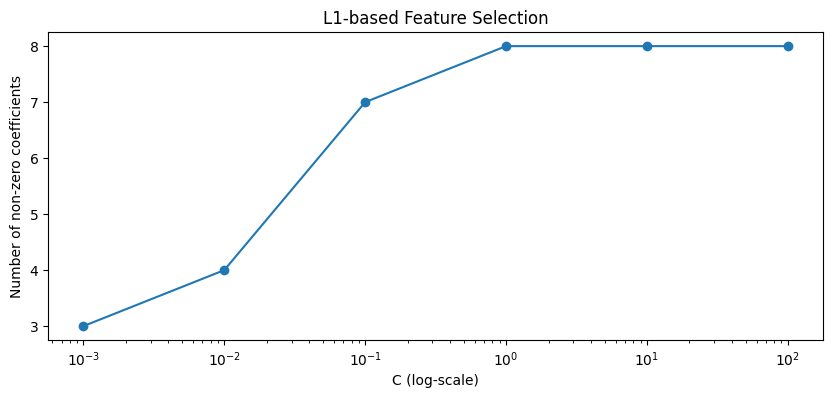

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,4))

plt.plot(C_values, num_features_selected, marker='o')

plt.xscale('log')

plt.xlabel('C (log-scale)')
plt.ylabel('Number of non-zero coefficients')

plt.title('L1-based Feature Selection')

The following code summarises the results by printing the number of non-zero (i.e. selected) features for each value of C, helping us observe the trade-off between model simplicity and the number of features used.

In [10]:
for c, nf in zip(C_values, num_features_selected):
    print(f"C={c}: {nf} non-zero features")

C=0.001: 3 non-zero features
C=0.01: 4 non-zero features
C=0.1: 7 non-zero features
C=1: 8 non-zero features
C=10: 8 non-zero features
C=100: 8 non-zero features


A *smaller* `C` means *stronger* L1 penalty, hence more features driven to zero.

### Tree-based feature importances
Tree-based algorithms, such as Decision Trees, Random Forests, Gradient Boosting (e.g., XGBoost, LightGBM, CatBoost), and Extra Trees, provide a built-in mechanism for evaluating feature importance. Unlike statistical or wrapper-based methods, these models inherently assess the contribution of each feature to the prediction task during training. The importance score for each feature is derived from how frequently it is used in splitting nodes and how much it reduces the impurity (e.g., Gini impurity or entropy in classification, or variance reduction in regression).

In Random Forests, which aggregate multiple decision trees, the feature importance is computed by averaging the impurity reduction across all trees in the ensemble. Features that frequently result in significant error reduction are assigned higher importance scores. Similarly, Gradient Boosting models, such as XGBoost and LightGBM, calculate feature importance based on how much each feature contributes to reducing the model’s overall loss function across multiple boosting iterations.

One advantage of tree-based feature importance is that it captures feature interactions—unlike simpler methods that assess features independently. However, these importance scores can sometimes be biased toward features with higher cardinality (i.e., features with more unique values). Additionally, while they provide insight into which features contribute most to the model, they do not inherently perform feature selection. If needed, features with very low importance can be removed to improve model efficiency without significantly impacting performance.

In scikit-learn, you can obtain feature importances from a trained Random Forest model as follows:

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the full dataset (X: features, Y: labels)
rf.fit(X, Y)

# Get the importance of each feature as calculated by the trained model
# Higher values mean the feature had more influence on predictions
importances = rf.feature_importances_

# Create a dictionary mapping feature names to their importance scores
# Assumes the first 8 column names are stored in `header[:8]`
feature_importance_dict = dict(zip(header[:8], importances))

# Loop through each feature and its importance, printing the results
for fname, imp in feature_importance_dict.items():
    print(fname, "->", round(imp, 3))  # Round importance to 3 decimal places for readability


Pregnancy_Count -> 0.085
Glucone_conc -> 0.267
Blood_pressure -> 0.089
Skin_thickness -> 0.065
Insulin -> 0.072
BMI -> 0.169
DPF -> 0.123
Age -> 0.132


Text(0.5, 1.0, 'Random Forest Feature Importances')

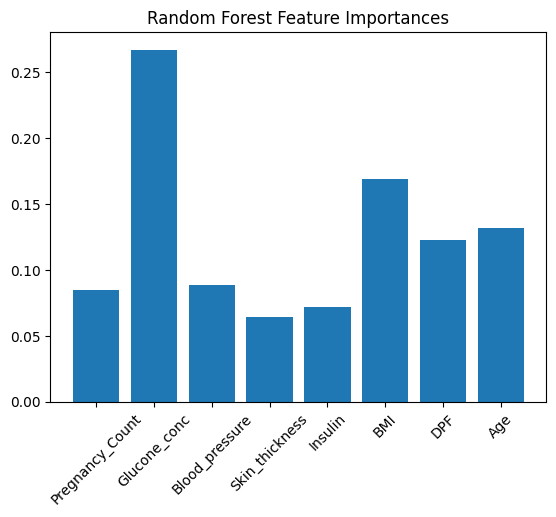

In [19]:
plt.bar(range(len(importances)), importances, tick_label=header[:8])

plt.xticks(rotation=45)

plt.title('Random Forest Feature Importances')

We can rank or threshold these importance scores to select key features if desired.


### Dimensionality Reduction (PCA)

Principal Component Analysis (PCA) is a popular dimensionality reduction technique that transforms a high-dimensional dataset into a smaller set of principal components. Each principal component is a linear combination of the original features and is designed to capture the maximum variance in the data. The goal of PCA is not to select a subset of existing features, but rather to create a new feature space that retains the most informative patterns while reducing redundancy. This makes it especially useful for datasets with many correlated variables, as PCA helps eliminate multicollinearity and improves model efficiency.

Unlike traditional feature selection, which keeps a subset of original features, PCA projects data into a new coordinate system. This means that the transformed features (principal components) are not directly interpretable in terms of the original variables. However, they still preserve most of the information, making PCA particularly valuable for high-dimensional numeric datasets where reducing the number of features can enhance computational efficiency without significantly compromising performance.

#### Steps to perform PCA on a data set
- Standardise the data (if necessary) – Since PCA is affected by scale, it is common to normalise features so that each has zero mean and unit variance.
- Compute the Covariance Matrix – This measures how features vary together.
- Perform Eigenvalue Decomposition – The eigenvectors represent the principal components, while eigenvalues indicate the amount of variance each component captures.
- Sort and select Principal Components – The components are ranked based on their explained variance, and only the top k components are kept, reducing the dimensionality of the dataset.
- Lastly, choosing the number of components to use for our model.

To determine the optimal number of principal components, we often look at the explained variance ratio, which indicates how much of the total variance each component captures. A common approach is to select enough components to explain at least 90–95% of the variance, balancing dimensionality reduction with information retention:

In [13]:
from sklearn.decomposition import PCA  
from sklearn.preprocessing import StandardScaler 

# Standardise the feature data (mean = 0, standard deviation = 1)
# This is important for PCA because it is sensitive to the scale of the features
X_scaled = StandardScaler().fit_transform(X)

# Create a PCA object (no components specified, so it will keep all of them)
pca = PCA()

# Fit PCA to the scaled data and transform it
# This projects the original features into a new set of uncorrelated components
X_pca = pca.fit_transform(X_scaled)

Let's visualise the results:

Text(0.5, 1.0, 'Explained Variance by Number of Components')

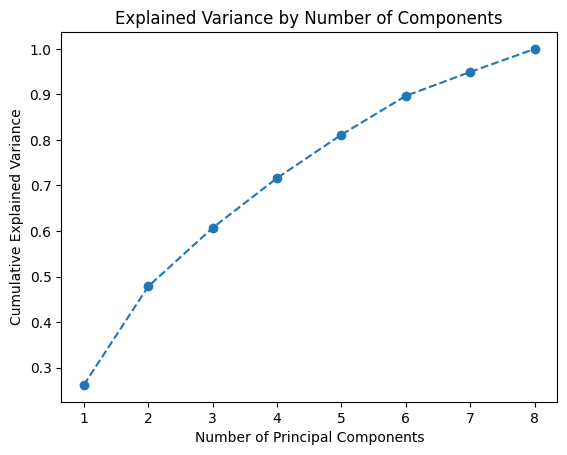

In [14]:
# Plot explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

plt.title('Explained Variance by Number of Components')

*Note*: Combining PCA with *scaling* is common if features have very different scales. So ensure you explore the dataset first, and determine whether this is required.


### Comparing performance before and after
Finally, let’s see if feature selection changes a model’s accuracy. We will train logistic regression on the following:

1. All features 8 features.
2. Top 6 features using chi-square.

We will take a sample of our data for training, and one for testing (more on this later).
We then create the model and train it on the training data and evaluate it on the test data to see how well it performed in predicting diabetes given the patient records (with all training data, and a reduced collection of selected columns, or features):

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score  # For splitting data and cross-validation - more on this later
from sklearn.linear_model import LogisticRegression  
from sklearn.feature_selection import SelectKBest, chi2 

# Split the dataset into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a logistic regression model using the 'liblinear' solver (suitable for small datasets)
model = LogisticRegression(solver='liblinear')

# Train and evaluate using all features
model.fit(X_train, y_train)  # Fit model on training data
score_all = model.score(X_test, y_test)  # Evaluate accuracy on test set
print("Accuracy (all features):", score_all)

# Train and evaluate using only top 6 features selected by Chi-squared test
selector = SelectKBest(score_func=chi2, k=6)  # Select top 6 features based on chi2 scores

# Fit selector on training data and transform both train and test sets
Xk_train = selector.fit_transform(X_train, y_train)
Xk_test = selector.transform(X_test)

# Create a new logistic regression model for the reduced feature set
model_k = LogisticRegression(solver='liblinear')

# Train the model with the selected features
model_k.fit(Xk_train, y_train)

# Evaluate the model on the test set with selected features
score_k = model_k.score(Xk_test, y_test)
print("Accuracy (top 6 chi2):", score_k)


Accuracy (all features): 0.7597402597402597
Accuracy (top 6 chi2): 0.7662337662337663


Whether feature selection enhances model accuracy depends on multiple factors, including the dataset characteristics, the selection method used, and model tuning. In some cases, removing certain features improves generalisation by reducing overfitting, while in others, it may discard valuable information, leading to decreased performance.

## What have we learnt?
We covered filter-based, wrapper-based, and embedded feature selection techniques, along with PCA for dimensionality reduction. Filter-based methods quickly eliminate features using statistical measures like variance, correlation, or chi-square tests. Wrapper-based methods, such as Recursive Feature Elimination (RFE), iteratively evaluate feature subsets but can be computationally expensive. Embedded methods integrate feature selection within model training, as seen in L1-regularised logistic regression or tree-based models like random forests. PCA reduces dimensionality by projecting data into a smaller number of principal components, retaining variance but losing direct interpretability of original features.

In practice, feature selection should be approached experimentally, testing multiple techniques to find the best balance between model accuracy, efficiency, and interpretability. These principles apply across various fields, including finance, bioinformatics, and predictive maintenance, where reducing irrelevant features can enhance performance and simplify analysis.